In [1]:
import argparse
import numpy as np
import os
import torch
import tifffile as tiff

from video_depth_anything.video_depth import VideoDepthAnything
from utils.dc_utils import read_video_frames, save_video
from torchinfo import summary
import time
import psutil
from datetime import datetime
from datasets.Kitti import KITTI
from einops import rearrange
from utils.metrics import OutlierRatio, SignedRelativeDifference_Error, AbsoluteRelativeDifference_Error, MeanSquared_Error, AbsoluteDifference_Error
from utils.metrics import Outlier, SignedRelativeDifference, AbsoluteDifference, MeanSquared, AbsoluteRelativeDifference
from utils.align import align_prediction
import matplotlib.pyplot as plt
import imageio

from video_depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
import cv2
from tqdm import tqdm

In [2]:
device = 'cuda:0'
output_dir = './outputs'

encoder = 'vits'
process_single_image = True
inference_length = 32
keyframe_list = [20]
align_each_new_frame = False
skip_tmp_block = False

max_len = -1
target_fps = 10 # KITTI: 10
max_res = 1280
input_size = 518

# Datset sample 
i = 18
DEVICE = device if torch.cuda.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
}

video_depth_anything = VideoDepthAnything(**model_configs[encoder])
video_depth_anything.load_state_dict(torch.load(f'./checkpoints/video_depth_anything_{encoder}.pth', map_location='cpu'), strict=True)

video_depth_anything = video_depth_anything.to(DEVICE).eval()
dataset = KITTI(is_val=False)

sample = dataset[i]

scene_name = dataset.sample_list[i]
scene_name = scene_name['image'][0].split('/')[8] + '_cam'+dataset.sample_list[i]['cameraID']

frames = (rearrange(sample['image'].numpy(), 'b c h w -> b h w c') * 255).astype(np.uint8)
fps = 10
target_fps = 10
total_images = len(frames)


print(scene_name, 'Frames: ', total_images)
name = f'{encoder}_singleImage{str(process_single_image)}_align_each_new{align_each_new_frame}_{str(inference_length)}_{str(keyframe_list)}_{scene_name}.mp4'

2011_09_26_drive_0027_sync_cam3 Frames:  178


In [3]:
INFER_LEN = 32
OVERLAP = 10
KEYFRAMES = [0,12,24,25,26,27,28,29,30,31]
INTERP_LEN = 8

frame_height, frame_width = frames[0].shape[:2]
ratio = max(frame_height, frame_width) / min(frame_height, frame_width)
if ratio > 1.78:  # we recommend to process video with ratio smaller than 16:9 due to memory limitation
    input_size = int(input_size * 1.777 / ratio)
    input_size = round(input_size / 14) * 14

transform = Compose([
    Resize(
        width=input_size,
        height=input_size,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])
# Calculate length of appended frame list and extend
frame_list = [frames[i] for i in range(frames.shape[0])]
frame_step = INFER_LEN - OVERLAP
org_video_len = len(frame_list)
append_frame_len = (frame_step - (org_video_len % frame_step)) % frame_step + (INFER_LEN - frame_step)
frame_list = frame_list + [frame_list[-1].copy()] * append_frame_len

depth_list = []
pre_input = None  # pre_input: [b, frames, channels, height, width] same as curr_input to calculate overlap

cur_list = []
for frame_id in tqdm(range(0, org_video_len, frame_step)):
    for i in range(INFER_LEN):
        cur_list.append(torch.from_numpy(transform({'image': frame_list[frame_id+i].astype(np.float32) / 255.0})['image']).unsqueeze(0).unsqueeze(0))
    cur_input = torch.cat(cur_list, dim=1).to(device)  # cur_input: [1, 32, 3, 280, 924], [batch_size, frames, channel, height, width]; min: -3.2, max: 3.1
    break

    

  0%|          | 0/9 [00:00<?, ?it/s]


In [4]:
cur_input.size()

test_input = cur_input[:, :1, :, :, :]

test_input.size()

torch.Size([1, 1, 3, 280, 924])

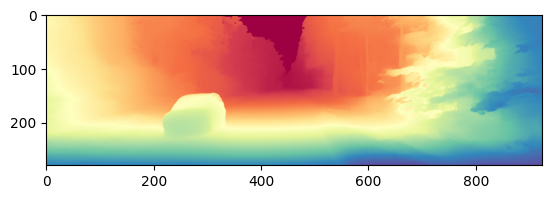

In [9]:
with torch.no_grad():
    with torch.autocast(device_type=device, enabled=(not False)):
        depth = video_depth_anything.forward(test_input, skip_tmp_block) # depth shape: [1, T (frames), H (height), W (width)], min: 0, max: 2390

plt.imshow(rearrange(depth.cpu().numpy()[0], 'c h w -> h w c'), cmap='Spectral')
plt.show()

# Handling of Keyframes 

In [15]:
orig_video_length = 447
frame_list = np.ones((447, 1242, 3))


inference_length = 32 # Complete length of processed Context
keyframe_list = [44, 12] # Distance to the last frame of the processed context. Exception 0 means always frame 0  START WITH HIGHEST DISTANCE, WE ALWAYS USE KEYFRAME 0
align_on_each_new_frame = True
max_keyframe = max(keyframe_list)

assert inference_length > len(keyframe_list) + 2 # Because 0 is always a keyframe; 1 new Frame must be predicted 

# In Loop
cur_frame = np.ones((1, 1, 3, 280, 924))
layer_1, layer_2, layer_3, layer_4 = torch.ones((1, 48, 80, 264)), torch.ones((1, 96, 40, 132)), torch.ones((1, 192, 20, 66)), torch.ones((1, 384, 10, 33))

motion_features = (np.ones((inference_length, 48, 80, 264)), np.ones((inference_length, 96, 40, 132)), np.ones((inference_length, 192, 20, 66)), 
                   np.ones((inference_length, 384, 10, 33)))

In [22]:
# prepare tensor for saving: 
features_l1 = torch.zeros((inference_length+max_keyframe, *layer_1.size()))
features_l2 = torch.zeros((inference_length+max_keyframe, *layer_2.size()))
features_l3 = torch.zeros((inference_length+max_keyframe, *layer_3.size()))
features_l4 = torch.zeros((inference_length+max_keyframe, *layer_4.size()))

# We need the following lists: 
# Motion_feature_idx: Which motion features to keep -- Should be always the same 




# Depth_pred_idx: which depth idx to predict on the prepared motion feautes 
# Aling depth idx: On which predicted idx to aling 


distance_to_batch = [keyframe_list[idx] + (inference_length-len(keyframe_list)) for idx in range(len(keyframe_list))]

static_keyframes = []
for idx in range(len(keyframe_list)):
    if inference_length > keyframe_list[idx]:
        static_keyframes.append(inference_length - keyframe_list[idx])
    elif inference_length <= keyframe_list[idx]:
        static_keyframes.append(idx+1)
assert not len(static_keyframes) != len(set(static_keyframes)), f'Setup leads to duplicates in the keyframes: {static_keyframes}'



Abs_depth_idx = [] #Absoluter index des Frames 
Align_idx = [] #Relativer index des frames within prediction batch 
use_feature_idx = [] #index der zu benutzenden feauters 
for frame_idx in range(inference_length-1, inference_length+max_keyframe+1, 1):

    tmp_batch_idx = [idx for idx in range(frame_idx-(inference_length-1), frame_idx, 1)]
    tmp_batch_idx[0] = 0 # We always use first frame as reference
    align_idx_batch = [0]
    
    for idx, static_keyframe in enumerate(static_keyframes):
        if static_keyframe in tmp_batch_idx:
            align_idx_batch.append(tmp_batch_idx.index(static_keyframe))
        else:
            if frame_idx-distance_to_batch[idx] <= static_keyframe:
                tmp_batch_idx[idx+1] = static_keyframe
                align_idx_batch.append(idx+1)
            else:
                tmp_batch_idx[idx+1] = static_keyframe + (frame_idx - distance_to_batch[idx] - static_keyframe)
                align_idx_batch.append(idx+1)
    use_feature_idx.append(tmp_batch_idx)
    Align_idx.append(align_idx_batch)
# up to inference_length+max_keyframe use_featuer_idx[:len(keyframe_list)+1] == Align_idx == Depth_pred_idx, da alles was bisher predicted wurde drin auch noch gespeichert ist. 
# Danach schiebt sich Align_idx und Depth_pred_idx immer um die differenz von frame_idx - inference_length+max_keyframe weiter. 
for i in range(len(use_feature_idx)):
    print(use_feature_idx[i])
    print(Align_idx[i])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0, 1, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 19]
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[0, 1, 18]
[0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0, 1, 17]
[0, 1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[0, 1, 16]
[0, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[0, 1, 15]
[0, 1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
[0, 1, 14]
[0, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,

In [9]:
static_keyframes


[1, 20]

In [7]:
distance_to_batch

[74, 42]

In [31]:
first_frame_depth_idx

NameError: name 'first_frame_depth_idx' is not defined

In [32]:
static_keyframes

[1, 2]